# Bike highways - revisit manually

After AWS and PyCaret it's still nice to do a bit of predicting ourselves. Let's load the same dataset (again) and see of any of the models we saw will be able to provide a good prediction.

In [1]:
import pandas as pd

df = pd.read_csv('../files/bike_counters_data/Measured data-nl-Geel_FMN GV 21 Geel.csv')

df["date_time"] = df["Datum"] + " " + df["Tijd"]
df["date_time"] = pd.to_datetime(df["date_time"])
df = df.set_index("date_time")
df = df[["Aantal fietsers"]]
df.head()

,Aantal fietsers
date_time,
2020-02-14 00:00:00,0
2020-02-14 01:00:00,0
2020-02-14 02:00:00,0
2020-02-14 03:00:00,2
2020-02-14 04:00:00,0


First, group by month and plot the data.

<Axes: xlabel='date_time'>

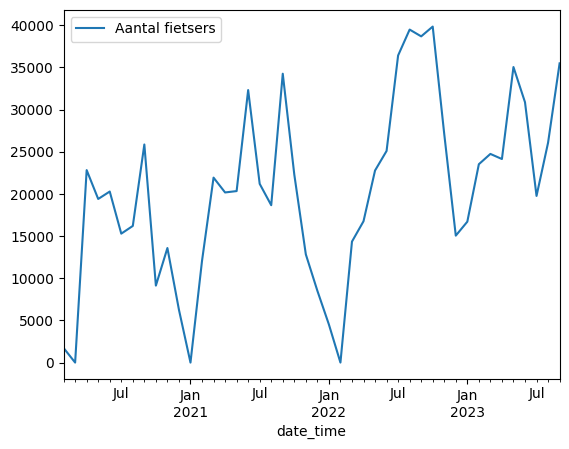

In [2]:
#DELETE
df_time_month = df.loc[ df["Aantal fietsers"] >= 30 ].resample('ME').sum().reset_index().set_index(['date_time'])
df_time_month.plot()

Next, calculate the autocorrection on this dataset. This should show us any seasonality that is in there.

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

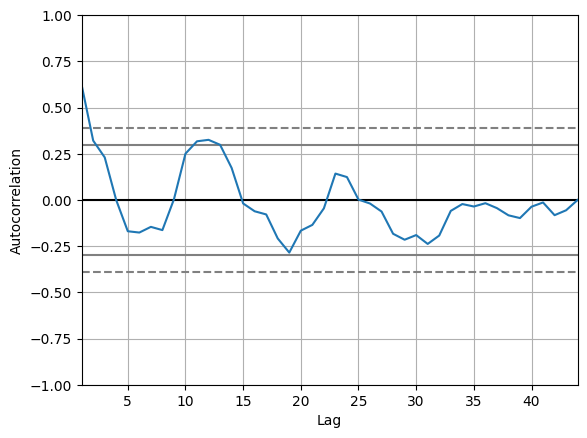

In [3]:
# DELETE

pd.plotting.autocorrelation_plot(df_time_month['Aantal fietsers'])

It's not as obvious as the example dataset, but there is a definite spike at 12 and 24 (months). And this is significant because we only have three years worth of data.

What if we group the data by day?

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

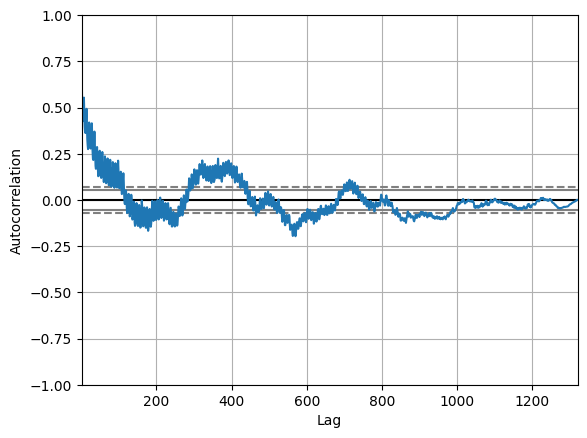

In [4]:
#DELETE
df_time_day = df.loc[ df["Aantal fietsers"] >= 30 ].resample('D').sum().reset_index().set_index(['date_time'])
# df_time_day.plot()
pd.plotting.autocorrelation_plot(df_time_day['Aantal fietsers'])

The same spike at 365 and 730! But not much higher, so we could simply keep on working with the monthly data...

## Arima

We'll apply an Arima-model to predict the number of cyclists. We'll try to predict the number per month.

Follow the following steps:

* Reload the excel file
* Set the date as index
* Drop all columns besides "Aantal fietsers"
* Resample as months
* Show the top 5 rows

In [5]:
# DELETE

import pandas as pd

df = pd.read_csv('../files/bike_counters_data/Measured data-nl-Geel_FMN GV 21 Geel.csv')[ ["Datum", "Aantal fietsers"] ]
df = df.loc[ df['Aantal fietsers'] > 1 ]
df["Datum"] = pd.to_datetime(df["Datum"])
df_months = df.resample('ME', on='Datum').sum()

df_months.head()

,Aantal fietsers
Datum,
2020-02-29,2062
2020-03-31,0
2020-04-30,26462
2020-05-31,22410
2020-06-30,23888


Good start. For auto-arima, our dataset should have:
* A date column named ds (currently the index)
* A value column named y (currently "Aantal fietsers")
* A column called "unique_id" that contains a value (the same for all rows)

The month-column should be stored as a date-time. Drop all other columns.

In [6]:
#DELETE
df_months["ds"]= df_months.index
df_months["y"]= df_months["Aantal fietsers"]
df_months['ds'] = pd.to_datetime(df_months['ds'])
df_months['unique_id'] = 'Cyclists'

df_months = df_months[["ds", "unique_id", "y"]]
# Sort by date just to be sure
df_months = df_months.sort_values('ds')
df_months.head()

,ds,unique_id,y
Datum,,,
2020-02-29,2020-02-29,Cyclists,2062
2020-03-31,2020-03-31,Cyclists,0
2020-04-30,2020-04-30,Cyclists,26462
2020-05-31,2020-05-31,Cyclists,22410
2020-06-30,2020-06-30,Cyclists,23888


We should tell the model how often our data appears. Here it is monthly, we resampled it to be that way. But let's determine it automatically anyway.

In [7]:
freq = pd.infer_freq(df_months['ds'])
freq

'ME'

Now chop of the last 12 months and put the remainder in a df_train.

In [8]:
#DELETE
df_train = df_months[:-12]
df_test = df_months[-12:]

And now we're ready to create and fit the model!

In [9]:
#DELETE
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA

# Initialize forecast engine
sf = StatsForecast(
    models=[AutoARIMA(season_length=12)],  # adjust season_length if needed
    freq=freq,
    n_jobs=-1  # use all CPUs
)

# Fit model on training data
sf_fitted = sf.fit(df_train)


And now predict the last 12 months of our data.

In [10]:
#DELETE
# Forecast next 12 periods
df_forecast = sf_fitted.predict(h=12)
print(df_forecast)


   unique_id         ds     AutoARIMA
0   Cyclists 2022-10-31  31762.550781
1   Cyclists 2022-11-30  22789.550781
2   Cyclists 2022-12-31  18079.550781
3   Cyclists 2023-01-31  12409.549805
4   Cyclists 2023-02-28   4948.549805
5   Cyclists 2023-03-31  21183.550781
6   Cyclists 2023-04-30  26279.550781
7   Cyclists 2023-05-31  31559.550781
8   Cyclists 2023-06-30  33735.550781
9   Cyclists 2023-07-31  43861.550781
10  Cyclists 2023-08-31  46640.550781
11  Cyclists 2023-09-30  47064.550781


Calculate the RMSE.

In [11]:
#DELETE
from sklearn.metrics import mean_squared_error
import numpy as np

# Forecast the next 12 months
df_forecast = sf.predict(h=12)
df_forecast["y"] = df_forecast["AutoARIMA"]

rmse = np.sqrt(mean_squared_error(df_test["y"], df_forecast["y"]))
print(f"RMSE on test set: {rmse:.4f} passengers")

RMSE on test set: 11910.0898 passengers


Kind of a big number. Maybe the graph will enlighten us?

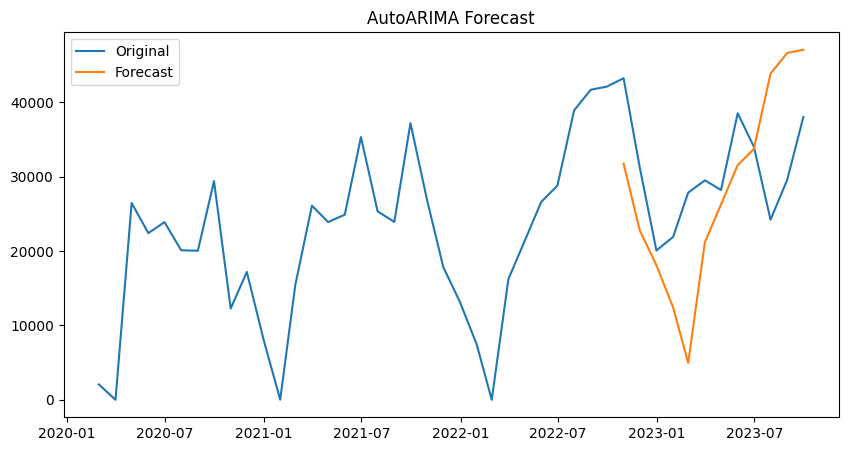

In [12]:
#DELETE
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(df_months['ds'], df_months['y'], label='Original')
plt.plot(df_forecast['ds'], df_forecast['AutoARIMA'], label='Forecast')
plt.legend()
plt.title("AutoARIMA Forecast")
plt.show()


The forecast isn't great, but roughly follows the data. Let's not forget we are working with about 40 months worth of data, which isn't anywhere near enough data for a reliable model. Main thing was getting a succesful pipeline (data -> prediction).